In [1]:
from joblib import Parallel, delayed
import functools

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd

import time
from tqdm import tqdm_notebook as  tqdm 

%pylab inline
pd.set_option('display.max_rows', 7)

Populating the interactive namespace from numpy and matplotlib


# Load  data

In [2]:
data = pd.read_csv(
    "trips.csv",
    header=None,
    names=['source', 'sink', 'correspndc', 'avg_time', 'avg_dist'])

data

,source,sink,correspndc,avg_time,avg_dist
0,1,1,40,26,2.2
1,1,2,4,49,8.1
2,1,3,3,35,6.8
...,...,...,...,...,...
207,22,1,1,140,84.8
208,22,2,3,120,72.6
209,22,22,18,25,1.5


$L_i$ - полное число людей, ездящих на работу из района $i$ (*source_volumes*)

$Q_j$ - полное число людей, приезжающих на работу в район $j$ (*sink_volumes*)

$(d_{real})_{ij}$ - реальная корреспонденция между районами $i$ и $j$ 

$\sum\limits_j (d_{real})_{ij} = L_i$

$\sum\limits_i(d_{real})_{ij} = W_j$

Заполним клетки, в которых отсутствует информация, inf-значениями, а соответствующую корреспонеднцию положим равной 0. 

In [3]:
num_of_regions = 22
for source_num in range(1, num_of_regions + 1):
    for sink_num in range(1, num_of_regions + 1):
        if not ((data['source'] == source_num) & (data['sink'] == sink_num)).any():
            df = pd.DataFrame(np.array([[source_num, sink_num, 0, np.Inf, np.Inf]]),
                              columns=['source','sink','correspndc', 'avg_time','avg_dist'])
            data = pd.concat([data, df], axis=0)
data.sort_values(by=['source','sink','correspndc', 'avg_time','avg_dist'], inplace=True)
data.reset_index(drop=True,inplace=True);

In [4]:
W = data[["sink", "correspndc"]].groupby(["sink"]).sum()["correspndc"].values
W = W.reshape((W.shape[0], 1))
L = data[["source", "correspndc",]].groupby(["source"]).sum()["correspndc"].values
L = L.reshape((W.shape[0], 1))

In [5]:
av_time = data["avg_time"].values.reshape(num_of_regions,
                                    num_of_regions).astype(float)
dist = data["avg_dist"].values.reshape(num_of_regions,
                                    num_of_regions).astype(float)
real_correspondance = data["correspndc"].values.reshape(
    num_of_regions, num_of_regions)

In [6]:
num_of_regions = 22

In [7]:
print(L.sum())
print(W.sum())

1965.0
1965.0


# Gravitational approach

**Гравитационная модель** восстановления матрицы корреспонденций:
$$d_{ij} = A_iB_jL_iW_jf(c_{ij})$$

Причем,
$$A_i = \left[\sum\limits_j B_jW_jf(c_{ij}) \right]^{-1}$$
$$B_j = \left[\sum\limits_i A_iL_if(c_{ij}) \right]^{-1} $$
$$d_{ij} = A_iB_jL_iW_jf(c_{ij})$$

A.shape - source_size * 1

B.shape - sink_size * 1

Далее все векторы - векторы столбцы

**Оптимизируемый функционал**:
$$\frac{\sum_{i, j}^n{(\hat{d_i,_j} - d_i,_j) ^ 2}}{n^2} \to \min$$
$d_{ij}$ - реальная матрица корресонденции,


$n =$ (num_of_regions)**2

In [9]:
def CalculateCorrespondance(A, B, gravity_func=None, **kwargs):
    return A * L * (B * W).T * gravity_func(**kwargs)

In [10]:
def iterate(A, B, gravity_func, **kwargs):
    A_p = (1 / ((B.T * W.T * gravity_func(**kwargs)).sum(axis = 1, keepdims=True)))
    B_p = (1 / ((A_p * L * gravity_func(**kwargs)).sum(axis = 0))).T
    return A_p.reshape(A.shape), B_p.reshape(B.shape)

In [143]:
def SinkhornBalance(
        loss_list=None,
        dA_list=None,
        dB_list=None,
        num_of_iterations=100,
        print_loss_on_break=True,
        A=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
        B=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
        gravity_func=None,
        **kwargs):

    for iter_num in range(1, num_of_iterations + 1):
        A_n, B_n = iterate(A, B, gravity_func, **kwargs)
        dA = np.linalg.norm(A - A_n, 2) / np.linalg.norm(A, 2)
        dB = np.linalg.norm(B - B_n, 2) / np.linalg.norm(B, 2)
        if (dA <= 1e-4) and (dB <= 1e-4):
            if print_loss_on_break:
                print("Process converged with final loss:", 
                     np.round(Loss(real_correspondance,
                     CalculateCorrespondance(A_n, B_n, gravity_func, **kwargs)), 3))
                print("Number of iterations:", iter_num)
            break
        if dA_list is not None:
            
            dA_list.append(dA)
            dB_list.append(dB)

        A, B = A_n, B_n
        if loss_list is not None:
            loss_list.append(
                Loss(real_correspondance,
                     CalculateCorrespondance(A, B, gravity_func, **kwargs)))
    return A, B

In [22]:
def Loss(correspondance, real_correspondance):
    return np.sum((real_correspondance - correspondance) * 
                  (real_correspondance - correspondance)) / (num_of_regions ** 2)

In [62]:
def CalcLoss(num_iterations=1000,print_loss_on_break=False, gravity_func=None, **kwargs):
    A, B = SinkhornBalance(
        num_of_iterations=num_iterations,
        print_loss_on_break=False,
        gravity_func=gravity_func,
        **kwargs)
    correspondance = CalculateCorrespondance(
        A, B, gravity_func=gravity_func,  **kwargs)
    return Loss(correspondance, real_correspondance)

In [47]:
def visualize_loss(loss_list):
    X = np.linspace(0, len(loss_list), len(loss_list))

    plt.figure(figsize=(17, 5))

    plt.title("loss")
    plt.xlabel("iter_num")
    plt.ylabel("loss")
    plt.plot(X, loss_list, 'purple')
    plt.plot(X, 0*X, "black")

In [48]:
def visualize_dcoef(dA_list, dB_list):
    X = np.linspace(0, len(dA_list), len(dA_list))

    plt.figure(figsize=(12, 5))

    plt.title("d_coeff / coeff")
    plt.xlabel("iter_num")
    plt.plot(X, dA_list, 'b', label='dA/A')
    plt.plot(X, dB_list, 'purple', label='dB/B')
    plt.plot(X, 0*X, "black")
    plt.ylim(top=0.5, bottom=0)
    plt.legend(loc='upper right')

**Write to file:**

In [49]:
def write_corresp(text_to_insert, target_file,  modeled_corresp, 
                  real_corresp=real_correspondance):
    with open(target_file, "w") as file:
        file.write(text_to_insert +"\n")
        file.write("{:<8}{:<8}{:<10}{:<10}\n\n".format("Source",
                                                     "Sink",
                                                     "Real Corresp",
                                                     "Modeled Corresp"))
        for source_id in range(num_of_regions):
            for sink_id in range(num_of_regions):
                real_value = real_correspondance[source_id][sink_id]
                modeled_value = modeled_corresp[source_id][sink_id]
                file.write("{:<8}{:<8}{:<10}{:<10}\n".format(source_id+1,
                                                             sink_id+1,
                                                             real_value,
                                                             modeled_value))
                

## Простая экспоненциальная модель. Затраты - среднее время.

$f(c_{ij}) = \dfrac{1}{\exp(\alpha c_{ij})}$

In [196]:
def simple_exp_time(alpha=0.1, costs=av_time):
    return 1 / np.exp(alpha * costs)

**Инициализация нулями**

In [145]:
loss_list = []
dA_list = []
dB_list = []
alpha = 0.046
num_of_iterations =100000
A, B = SinkhornBalance(
    A=np.ones((num_of_regions, 1)),
    B=np.ones((num_of_regions, 1)),
    loss_list=loss_list,
    dA_list=dA_list,
    dB_list=dB_list,
    num_of_iterations=num_of_iterations,
    gravity_func=simple_exp_time,
    alpha=alpha,
    costs=av_time)

correspondance = CalculateCorrespondance(
    A, B, simple_exp_time, alpha=alpha, costs=av_time)

Process converged with final loss: 23.286
Number of iterations: 85


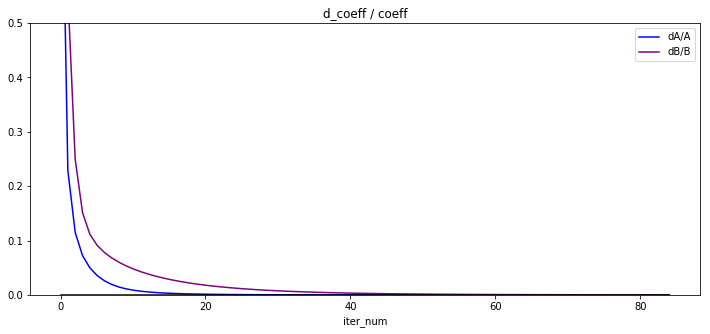

In [146]:
visualize_dcoef(dA_list, dB_list)

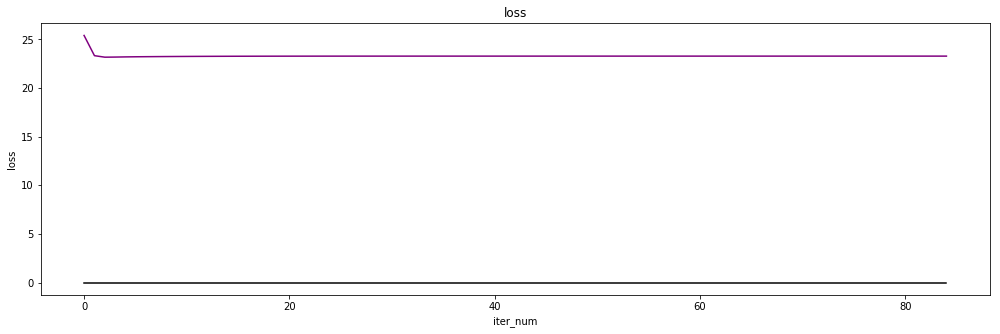

In [147]:
visualize_loss(loss_list)

**Случайная инициализация**

In [148]:
loss_list = []
dA_list = []
dB_list = []
alpha = 0.046
num_of_iterations = 10000
A, B = SinkhornBalance(
    A=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
    B=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
    loss_list=loss_list,
    dA_list=dA_list,
    dB_list=dB_list,
    num_of_iterations=num_of_iterations,
    gravity_func=simple_exp_time,
    alpha=alpha,
    costs=av_time,)

correspondance = CalculateCorrespondance(A, B, simple_exp_time,alpha=alpha, costs=av_time)

Process converged with final loss: 23.286
Number of iterations: 84


Инициализация А и В не сильно влияет на скорость сходимости и результат.

**Найдем оптимальный $\alpha$**

In [149]:
res = []
alphas = list(np.arange(0.01, 0.4, 1e-3))


num_iterations = 1000
for alpha in tqdm(alphas):
    r = CalcLoss(num_iterations, gravity_func=simple_exp_time, 
                            alpha=alpha)
    res.append(r)
res = np.array(res)

In [150]:
np.argwhere(res == res.min())

array([[66]])

In [151]:
print("loss:", res.min())
best_alpha = np.round(alphas[np.argwhere(res == res.min())[0][0]], 3)
print("best_alpha:", best_alpha)

loss: 15.264379242344114
best_alpha: 0.076


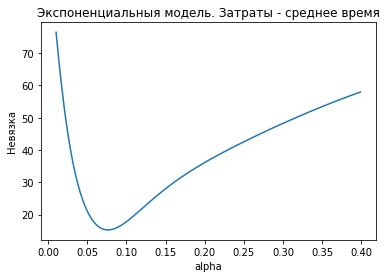

In [152]:
plt.title("Экспоненциальныя модель. Затраты - среднее время")
plt.plot(alphas, res)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

## Экспоненциальная модель. Затраты - комбинация среднего времени и расстояния

 $f(c_{ij}) = \dfrac{1}{\exp(\alpha r^\beta t^\gamma)}$

In [87]:
def exp_dist_time(alpha=0.01, beta=0, gamma=1):
    return 1 / np.exp(alpha * np.power(dist, beta) * np.power(av_time, gamma))

In [88]:
loss_list = []
dA_list = []
dB_list = []
alpha = 0.05
beta = 0
gamma = 1
num_of_iterations = 2000
A, B = SinkhornBalance(
    loss_list=loss_list,
    dA_list=dA_list,
    dB_list=dB_list,
    num_of_iterations=num_of_iterations,
    gravity_func=exp_dist_time,
    alpha=alpha,
    beta=beta,
    gamma=gamma)

correspondance = CalculateCorrespondance(A, B, exp_dist_time, 
                                         alpha=alpha,
                                         beta=beta,
                                         gamma=gamma)

Process converged with final loss: 21.048
Number of iterations: 86


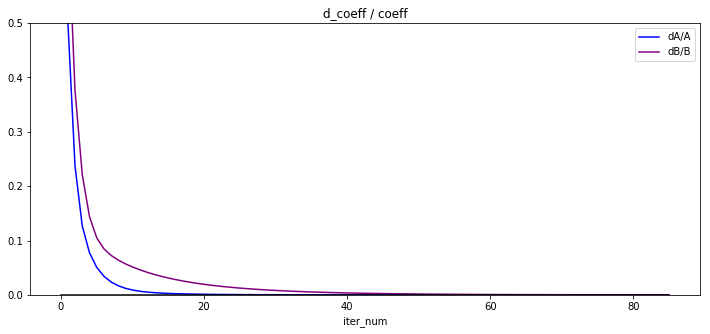

In [89]:
visualize_dcoef(dA_list, dB_list)

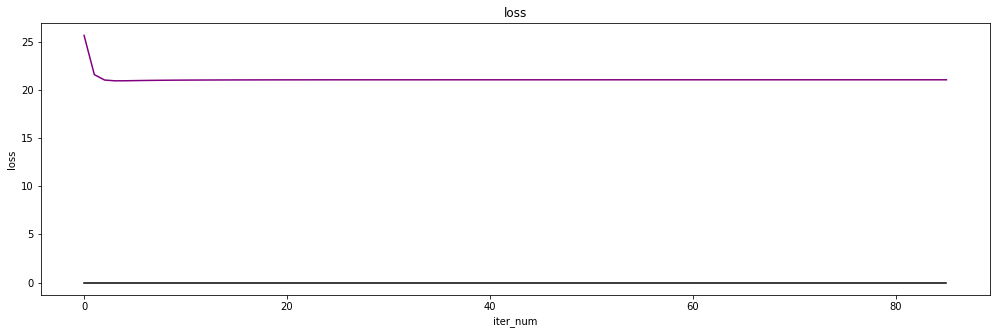

In [90]:
visualize_loss(loss_list)

**При фиксированном $\alpha$**

In [91]:
res = []
alpha = 0.076
betas = list(np.arange(0.00, 1, 0.15))
gammas = list(np.arange(0.00, 1, 0.1))

num_iterations = 500
for beta in tqdm(betas):
    res.append([])
    
    for gamma in gammas:
        r = CalcLoss(num_iterations, gravity_func=exp_dist_time, 
                            alpha=alpha,
                            beta=beta,
                            gamma=gamma)
        res[-1].append(r)

In [92]:
res = np.array(res)
print(res.min())

7.5204326851869805


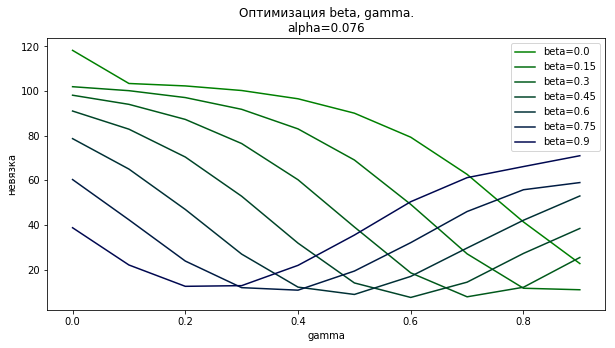

In [93]:
plt.figure(figsize=(10,5))

color=iter(cm.ocean(np.linspace(0,1,20)))


for it_num in range(len(list(betas))):
    c = next(color)
    beta = "beta=" + str(np.around(list(betas)[it_num], 3))
    plt.plot(gammas, res[it_num], label=beta,  c=c)
    
plt.xlabel("gamma")
plt.ylabel("невязка")
plt.legend(loc='upper right')
plt.title("Оптимизация beta, gamma.\nalpha=0.076")
plt.show()

**Перебор по всем 3 параметрам**

In [94]:
res = []
alphas = list(np.arange(0.01, 1, 0.1))
betas = list(np.arange(0.00, 1, 0.05))
gammas = list(np.arange(0.00, 1, 0.05))

num_iterations = 1000

for alpha in alphas:
    res.append([])
    for beta in betas:
        res[-1].append([])

        for gamma in gammas:
            r = CalcLoss(num_iterations, gravity_func=exp_dist_time, 
                                alpha=alpha,
                                beta=beta,
                                gamma=gamma)
            res[-1][-1].append(r)

/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


In [96]:
res = np.array(res)
res[np.isnan(res)] = np.inf

print("loss:", res.min())

loss: 4.895642474538356


In [97]:
best_alpha = np.around(alphas[np.argwhere(res==res.min())[0][0]], 3)
best_beta = np.around(betas[np.argwhere(res==res.min())[0][1]], 3)
best_gamma = np.around(gammas[np.argwhere(res==res.min())[0][2]], 3)
print('best_alpha={}, best_beta={}, best_gamma={}'.format(best_alpha, best_beta, best_gamma))

best_alpha=0.81, best_beta=0.3, best_gamma=0.2


**Запишем результаты в файл:**

In [98]:
loss_list = []
dA_list = []
dB_list = []
alpha = best_alpha
beta = best_beta
gamma = best_gamma
num_of_iterations = 10000
A, B = SinkhornBalance(
    A=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
    B=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
    loss_list=loss_list,
    dA_list=dA_list,
    dB_list=dB_list,
    num_of_iterations=num_of_iterations,
    gravity_func=exp_dist_time, 
                                alpha=alpha,
                                beta=beta,
                                gamma=gamma)

correspondance = CalculateCorrespondance(A, B, gravity_func=exp_dist_time, 
                                alpha=alpha,
                                beta=beta,
                                gamma=gamma)

Process converged with final loss: 4.896
Number of iterations: 78


In [103]:
write_corresp("f(c_ij) = 1\exp(alpha r^beta t^gamma).\nbest_alpha = {}, best_beta = {}, best_gamma = {}\n\n".format(best_alpha,
                                                         best_beta, best_gamma),
              "exp_dist_time", correspondance)

In [100]:
Loss(correspondance, real_correspondance)

4.8956417019071345

## Экспоненциальная модель. Затраты - среднее время. 2 параметра

$f(c_{ij}) = \dfrac{1}{\exp(\alpha t^\beta)}$

In [101]:
def exp_time(alpha=0.01, beta=1):
    return 1 / np.exp(alpha * (av_time**beta))

In [104]:
res = []
alphas = list(np.arange(0.01, 2, 0.1))
betas = list(np.arange(0.01, 0.8, 0.1))

num_iterations = 500
for alpha in tqdm(alphas):
    res.append([])
    for beta in betas:
        r = CalcLoss(num_iterations, gravity_func=exp_time, 
                            alpha=alpha,
                            beta=beta)
        res[-1].append(r)
res = np.array(res)

In [105]:
print("loss:",res.min())
best_beta = np.around(betas[np.argwhere(res==res.min())[0][1]], 3)
best_alpha = np.around(alphas[np.argwhere(res==res.min())[0][0]], 3)
print('best_alpha={}, best_beta={}'.format(best_alpha, best_beta))

loss: 12.954155252358817
best_alpha=1.81, best_beta=0.41


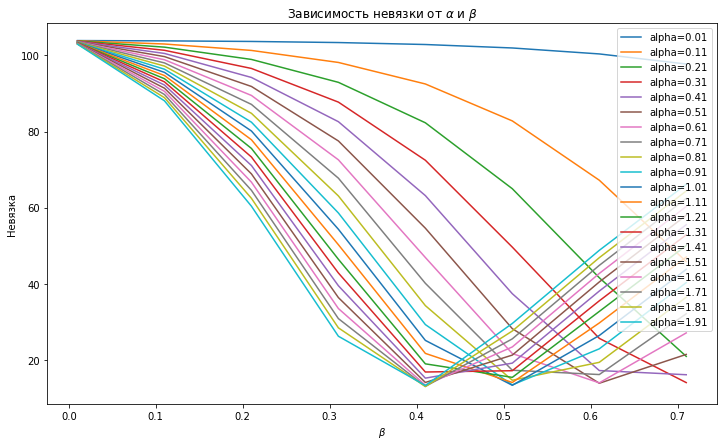

In [106]:
plt.figure(figsize=(12,7))

for it_num in range(len(list(alphas))):
    alpha = "alpha=" + str(np.around(alphas[it_num], 3))
    plt.plot(betas, res[it_num], label=alpha)
    
plt.xlabel(r"$\beta$")
plt.ylabel("Невязка")
plt.legend(loc='upper right')
plt.title(r"Зависимость невязки от $\alpha$ и $\beta$")
plt.show()

## Степенная функция потерь. Затраты - среднее время.

$f(c_{ij}) = \dfrac{1}{c_{ij}^\beta} = \dfrac{1}{e^{\beta \ln c_{ij}}}$

In [107]:
def power_func(beta, costs=av_time):
    return 1 / (np.power(costs, beta))

In [108]:
res = []
betas = list(np.arange(1.5, 4, 0.05))

num_iterations = 1000
for beta in betas:
    r = CalcLoss(num_iterations, gravity_func=power_func, beta=beta)
    res.append(r)
    
res = np.array(res)

In [109]:
print(res.min())

12.257720566426885


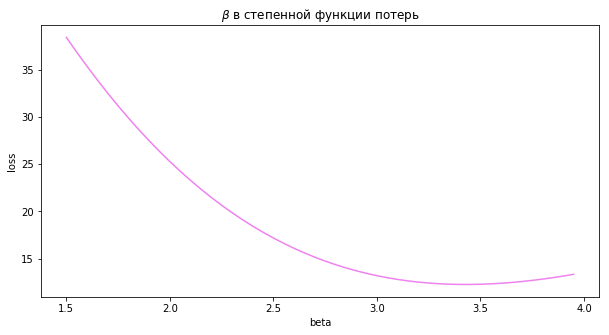

In [110]:
plt.figure(figsize=(10,5))
plt.plot(betas, res, c = "violet")
    
plt.xlabel("beta")
plt.ylabel("loss")
plt.title(r"$\beta$ в степенной функции потерь")
plt.show()

In [111]:
print("loss:", res.min())

loss: 12.257720566426885


In [112]:
best_beta = betas[np.argwhere(res == res.min())[0][0]]
print("best_beta: ", best_beta)

best_beta:  3.450000000000002


## Модель степенная + кобинированная

$f(c_{ij}) = c_{ij}^{w}\exp(-\alpha(c_{ij}^{\beta})) $

In [113]:
def superposition_grav_func(alpha, beta, w, costs=av_time):
    return np.where((costs < np.inf), (costs ** w) * np.exp(-alpha * (costs ** beta)), 0)

**Зафиксируем $\alpha$**

In [116]:
res = []
alpha = 0.1
betas = list(np.arange(0.1, 2, 0.5))
ws = list(np.arange(0.1, 5, 0.5))

num_iterations = 1000
for w in tqdm(ws):
    res.append([])
    for beta in betas:
        r = CalcLoss(num_iterations, gravity_func=superposition_grav_func,
                     alpha=alpha, beta=beta, w=w)
        res[-1].append(r)


res = np.array(res)
print(res.min())

/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


21.22733981188811


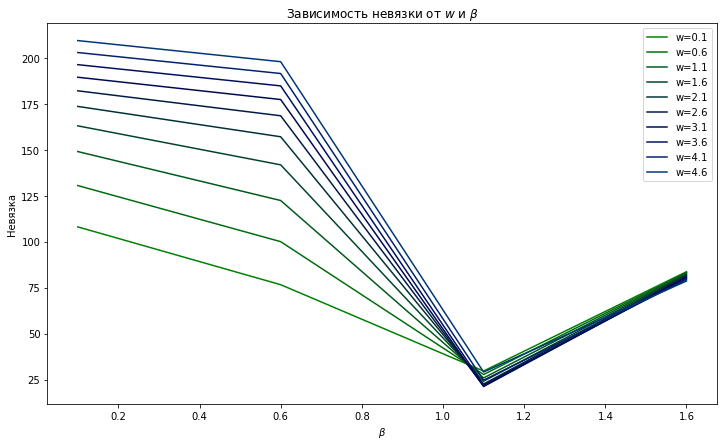

In [117]:
plt.figure(figsize=(12,7))

color=iter(cm.ocean(np.linspace(0,1,20)))
for it_num in range(len(ws)):
    label_betas = "w=" + str(np.around(ws[it_num], 3))
    plt.plot(betas, res[it_num], label=label_betas, c = next(color))
    
plt.xlabel(r"$\beta$")
plt.ylabel("Невязка")
plt.legend(loc='upper right')
plt.title(r"Зависимость невязки от $w$ и $\beta$")
plt.show()

**Перебор по всем 3 параметрам**

In [120]:
res = []
alphas = list(np.arange(0.19, 0.9, 0.1))
betas = list(np.arange(0.19, 0.9, 0.1))
ws = list(np.arange(1e-4, 0.3, 0.05))

num_iterations = 1000
for beta in tqdm(betas):
    res.append([])
    for alpha in alphas:
        res[-1].append([])
        for w in ws:
            r = CalcLoss(num_iterations, gravity_func=superposition_grav_func,
            alpha=alpha, beta=beta, w=w)
            res[-1][-1].append(r)

res = np.array(res)
print(res.min())

/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


13.543667619020184


In [121]:
res = np.array(res)
print(res.min())
print(np.argwhere(res==res.min()))
print("best alpha:", alphas[4])
print("best beta", betas[4])
print("best w:", ws[0])

13.543667619020184
[[4 4 0]]
best alpha: 0.5900000000000001
best beta 0.5900000000000001
best w: 0.0001


In [122]:
best_alpha = alphas[np.argwhere(res==res.min())[0][1]]
best_beta = betas[np.argwhere(res==res.min())[0][0]]
best_w = ws[np.argwhere(res==res.min())[0][2]]

## Модель с модифицированным хвостом

$R(l) =  \left\{
\begin{array}{ll}
\alpha l^{\beta} & \textrm{for } 0\leq l \le \hat l\textrm{,}\\
\nu \ln l & \textrm{for } l \geq \hat l\textrm{.}
\end{array} \right. $

$\hat l$ находим из условия что, $\alpha \hat l^{\beta} = \nu \ln \hat l$. 

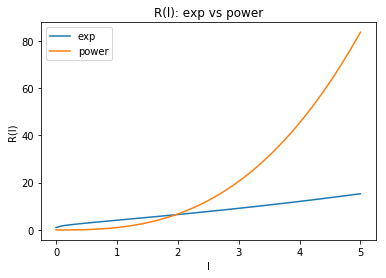

In [124]:
x_axis = np.linspace(0, 5, 50)
alpha = 1.41
beta = 0.41
nu = 2.75
plt.title("R(l): exp vs power")
plt.xlabel("l")
plt.ylabel("R(l)")
plt.plot(x_axis, np.exp(alpha * (x_axis**beta)),  label="exp")
plt.plot(x_axis[0:], x_axis[0:]**nu, label="power")
plt.legend(loc="best")
plt.show()

$f(c_{ij}) = \exp(-R(l)) =  \left\{
\begin{array}{ll}
\exp (-\alpha l^{\beta}) & \textrm{for } 0\leq l \le \hat l\textrm{,}\\
\dfrac{1}{l ^\nu}& \textrm{for } l \geq \hat l\textrm{.}
\end{array} \right. $



In [125]:
def mixed_grav_func(alpha, beta, nu, loss=av_time):
    return np.where((alpha * (loss**beta) >= nu * np.log(loss)) &
                    (alpha * beta * (loss**(beta-1)) > nu/loss),
                    1 / loss**nu, np.exp(-alpha * loss**beta))

In [129]:
res = []
alphas = list(np.arange(0.01, 2, 0.1))
betas = list(np.arange(0.01, 1.5, 0.1))
nus = list(np.arange(0.1, 3, 0.1))

num_iterations = 1000
for alpha in tqdm(alphas, desc='alpha loop', leave=True):
    res.append([])
    for beta in tqdm(betas,  desc='beta loop', leave=False):
        res[-1].append([])
        for nu in tqdm(nus, desc='nu loop', leave=False):
            r = CalcLoss(num_iterations, gravity_func=mixed_grav_func, 
                            alpha=alpha,
                            beta=beta,
                            nu=nu)
            res[-1][-1].append(r)


In [130]:
res = np.array(res)
res.min()

11.770214140634106

In [131]:
print(np.argwhere(res==res.min()))

best_alpha = alphas[np.argwhere(res==res.min())[0][0]]
best_beta = betas[np.argwhere(res==res.min())[0][1]]
best_nu = nus[np.argwhere(res==res.min())[0][2]]

print("best alpha:", best_alpha)
print("best beta", best_beta)
print("best nu:", best_nu)

[[15  5 26]]
best alpha: 1.51
best beta 0.51
best nu: 2.7


# Statistical approach

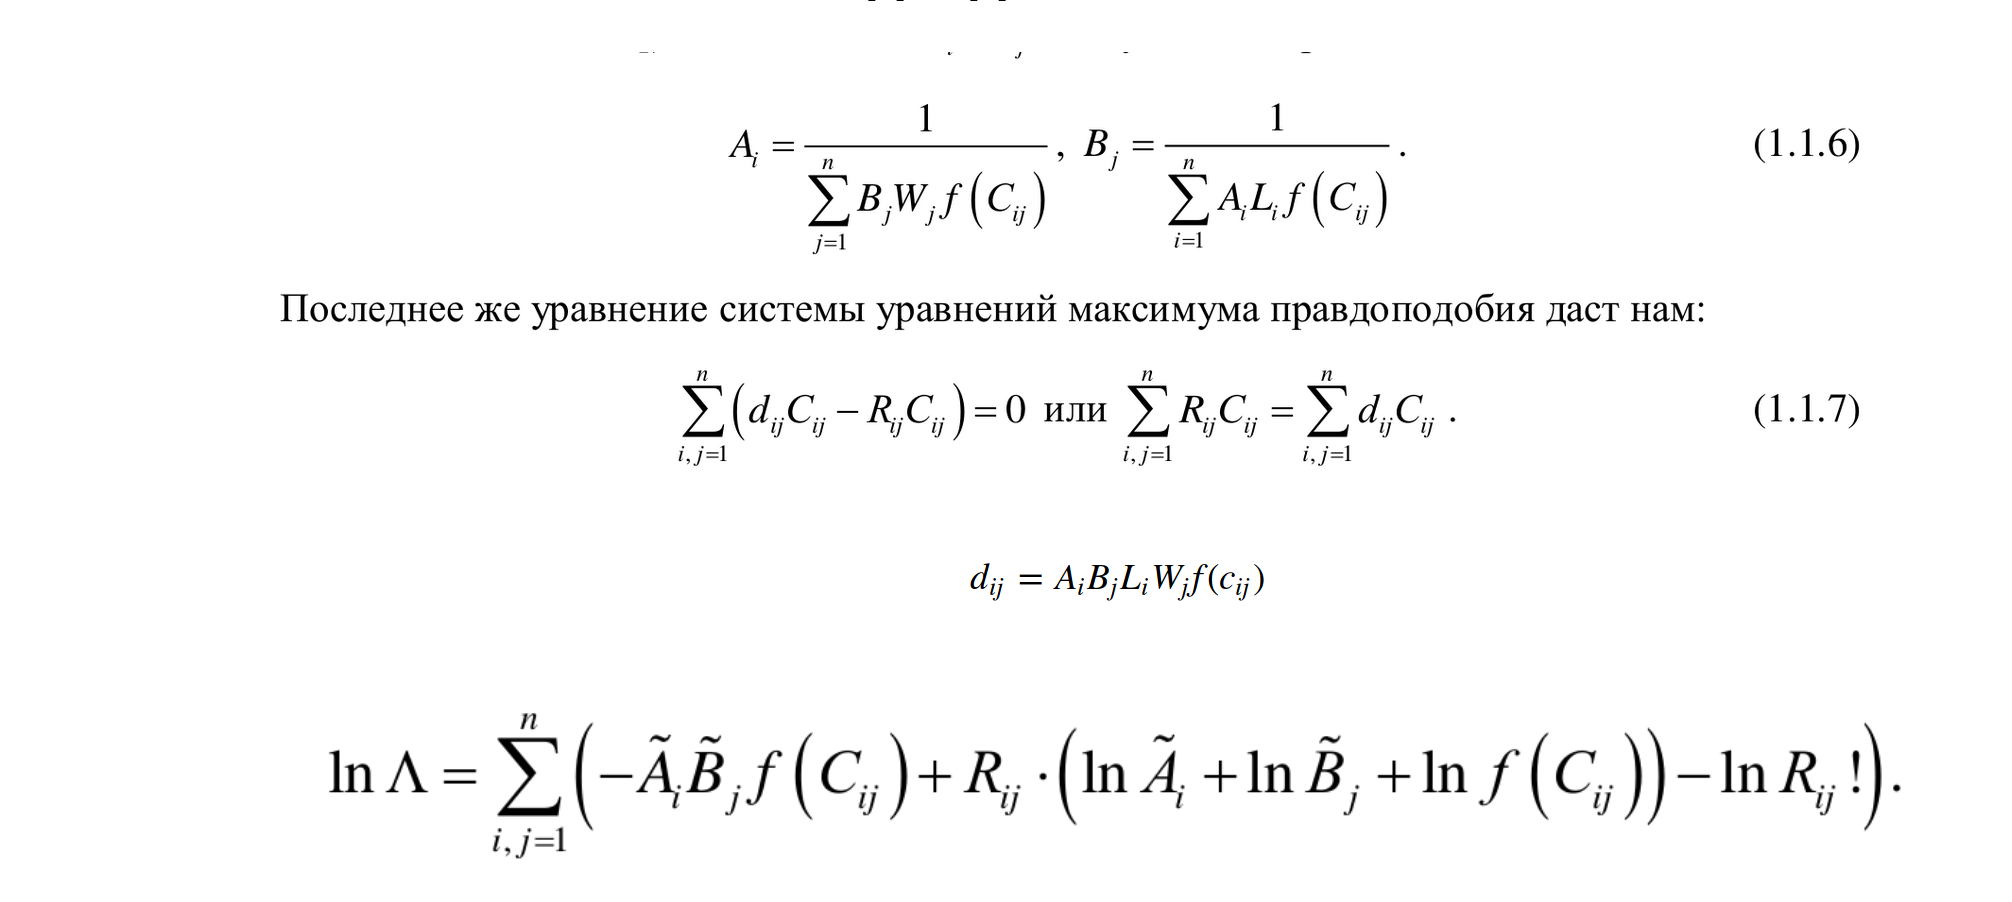

$difference = \sum_{i,j = 1,1}^{n,m}(d_{ij}^{real} - d_{ij})c_{ij}$

In [171]:
def CalcDifference(correspondance,
                    real_correspondance=real_correspondance,
                    costs=av_time):
    modified_costs = np.where(costs != np.inf, costs, 0)
    return np.sum((correspondance - real_correspondance) * modified_costs)

In [197]:
def CalcLogLh(correspondance,
                real_correspondance=real_correspondance,
                **kwargs):
    return np.sum(np.where(av_time != np.inf,
                  -correspondance +
                  real_correspondance *
                  np.log(correspondance), 0))

Немного изменим функциюю балансировки, чтобы в ней еще и считались логарифм правлоподобия

In [198]:
def SinkhornBalance(
        loss_list=None,
        log_lh_list=None,
        dA_list=None,
        dB_list=None,
        num_of_iterations=100,
        print_loss_on_break=True,
        A=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
        B=np.random.uniform(1e-8, 1, (num_of_regions, 1)),
        gravity_func=None,
        **kwargs):

    for iter_num in range(1, num_of_iterations + 1):
        A_n, B_n = iterate(A, B, gravity_func, **kwargs)
        dA = np.linalg.norm(A - A_n, 2) / np.linalg.norm(A, 2)
        dB = np.linalg.norm(B - B_n, 2) / np.linalg.norm(B, 2)
        if (dA <= 1e-4) and (dB <= 1e-4):
            if print_loss_on_break:
                print("Process converged with final loss:", 
                     np.round(Loss(real_correspondance,
                     CalculateCorrespondance(A_n, B_n, gravity_func, **kwargs)), 3))
                print("Number of iterations:", iter_num)
            break
        if dA_list is not None:
            
            dA_list.append(dA)
            dB_list.append(dB)

        A, B = A_n, B_n
        
        correspondance =  CalculateCorrespondance(A, B, gravity_func, **kwargs)
        if loss_list is not None:
            loss_list.append(
                Loss(real_correspondance,
                    correspondance))
        
        if log_lh_list is not None:
            log_lh_list.append(CalcLogLh(correspondance))
            
    return A, B

In [199]:
def visualize_log_lh(log_lh_list):
    X = np.linspace(0, len(log_lh_list), len(log_lh_list))

    plt.figure(figsize=(17, 5))

    plt.title("log likelyhood")
    plt.xlabel("iter_num")
    plt.ylabel("log likelyhood")
    plt.plot(X, log_lh_list, 'b')
    plt.legend(loc='upper right')

$f(c_{ij}) = \exp(-\alpha c_{ij})$

In [206]:
loss_list = []
log_lh_list = []
dA_list = []
dB_list = []
alpha = 0.1
num_of_iterations = 100
A, B = SinkhornBalance(
    loss_list=loss_list,
    log_lh_list=log_lh_list,
    dA_list=dA_list,
    dB_list=dB_list,
    num_of_iterations=num_of_iterations,
    gravity_func=simple_exp_time,
    alpha=alpha,
    costs=av_time)

correspondance = CalculateCorrespondance(A, B, simple_exp_time, 
                                          alpha=alpha, costs=av_time)

Process converged with final loss: 17.818
Number of iterations: 82


/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


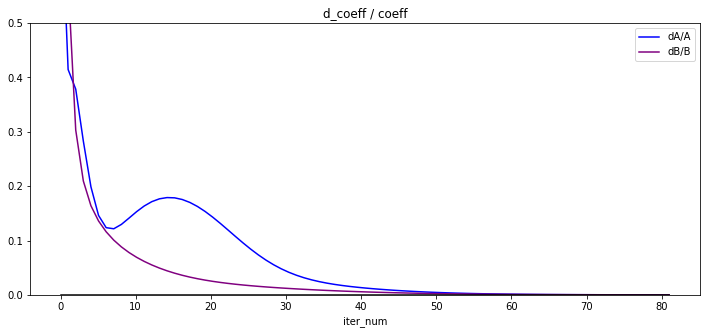

In [207]:
visualize_dcoef(dA_list, dB_list)

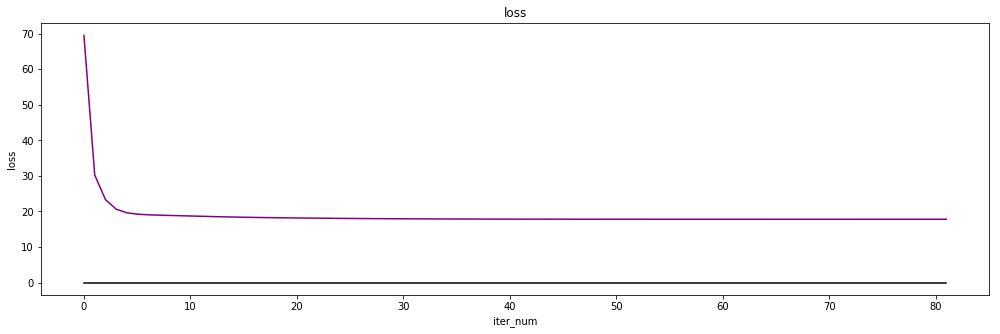

In [208]:
visualize_loss(loss_list)

No handles with labels found to put in legend.


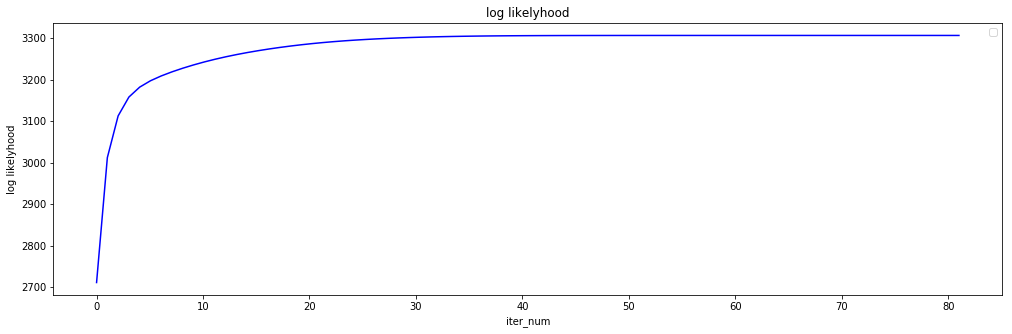

In [203]:
visualize_log_lh(log_lh_list)

In [209]:
CalcDifference(correspondance)

-15125.861541170108

**Перебор по $\alpha$**

In [210]:
diff_list = []
alphas = np.array(np.arange(0.01, 1, 0.01))
loss_list = []
log_lh_list = []
for alpha in tqdm(alphas):
    A, B = SinkhornBalance(
        num_of_iterations=num_of_iterations,
        print_loss_on_break=False,
        gravity_func=simple_exp_time,
        alpha=alpha,
        costs=av_time)

    correspondance=CalculateCorrespondance(
        A, B, simple_exp_time, alpha=alpha, costs=av_time)
    loss_list.append(Loss(correspondance, real_correspondance))
    diff_list.append(CalcDifference(correspondance, real_correspondance))
    log_lh_list.append(CalcLogLh(correspondance))


/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


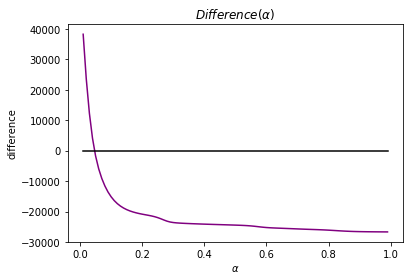

In [211]:
plt.figure()
plt.title(r"$Difference(\alpha)$")
plt.ylabel("difference")

plt.xlabel(r'$\alpha$')
plt.plot(alphas, diff_list, c='purple')
plt.plot(alphas, np.zeros_like(alphas), c='black')

In [213]:
diff_list = []
alphas = np.array(np.arange(0.01, 0.1, 0.01))
loss_list = []
log_lh_list = []
for alpha in tqdm(alphas):
    A, B = SinkhornBalance(
        num_of_iterations=num_of_iterations,
        print_loss_on_break=False,
        gravity_func=simple_exp_time,
        alpha=alpha,
        costs=av_time)

    correspondance=CalculateCorrespondance(
        A, B, simple_exp_time, alpha=alpha, costs=av_time)
    loss_list.append(Loss(correspondance, real_correspondance))
    diff_list.append(CalcDifference(correspondance, real_correspondance))
    log_lh_list.append(CalcLogLh(correspondance))


/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


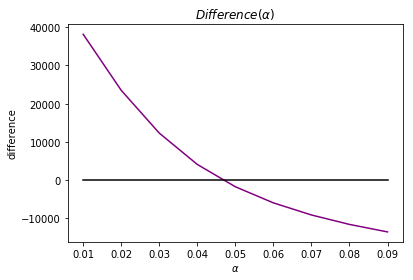

In [214]:
plt.figure()
plt.title(r"$Difference(\alpha)$")
plt.ylabel("difference")

plt.xlabel(r'$\alpha$')
plt.plot(alphas, diff_list, c='purple')
plt.plot(alphas, np.zeros_like(alphas), c='black')

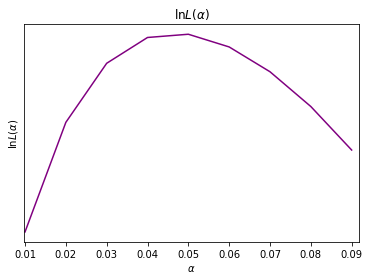

In [215]:
plt.figure()
plt.title(r"$\ln L(\alpha)$")
plt.ylabel(r"$\ln L(\alpha)$")
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.xlim((alphas[0]*0.98, alphas[-1]*1.02))
plt.plot(alphas, np.array(log_lh_list), c='purple')
plt.show()

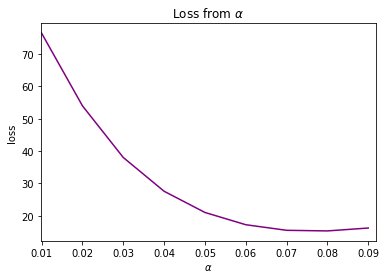

In [216]:
plt.figure()
plt.title(r"Loss from $\alpha$")
plt.ylabel("loss")
plt.xlabel(r'$\alpha$')
plt.xlim((alphas[0]*0.98, alphas[-1]*1.02))
plt.plot(alphas, loss_list, c='purple')
plt.show()

In [222]:
diff_list = []
alphas = np.array(np.arange(0.0445, 0.05, 5e-4))
loss_list = []
log_lh_list = []
for alpha in alphas:
    A, B = SinkhornBalance(
        num_of_iterations=num_of_iterations,
        gravity_func=simple_exp_time,
        alpha=alpha,
        costs=av_time)

    correspondance = CalculateCorrespondance(
        A, B, simple_exp_time, alpha=alpha, costs=av_time)
    loss_list.append(Loss(correspondance, real_correspondance))
    diff_list.append(CalcDifference(correspondance, real_correspondance))
    log_lh_list.append(CalcLogLh(correspondance))

Process converged with final loss: 24.249
Number of iterations: 83
Process converged with final loss: 23.92
Number of iterations: 83
Process converged with final loss: 23.599
Number of iterations: 83
Process converged with final loss: 23.286
Number of iterations: 83
Process converged with final loss: 22.98
Number of iterations: 83
Process converged with final loss: 22.682
Number of iterations: 83
Process converged with final loss: 22.392
Number of iterations: 83
Process converged with final loss: 22.109
Number of iterations: 83
Process converged with final loss: 21.833
Number of iterations: 83
Process converged with final loss:

/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/daria/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


 21.564
Number of iterations: 83
Process converged with final loss: 21.302
Number of iterations: 83
Process converged with final loss: 21.048
Number of iterations: 83


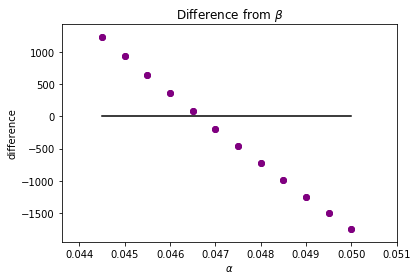

In [223]:
plt.figure()
plt.title(r"Difference from $\beta$")
plt.ylabel("difference")
plt.xlabel(r'$\alpha$')
plt.xlim((alphas[0]*0.98, alphas[-1]*1.02))
plt.scatter(alphas, diff_list, c='purple')
plt.plot(alphas, np.zeros_like(alphas), c='black')
plt.scatter(alphas, diff_list, c='purple')
plt.show()

**Определим операцию бинарного поиска**

In [227]:
alpha_min = 0.0445
alpha_max = 0.05


def binary_search_alpha(alpha_min, alpha_max,
                           max_num_of_iterations=1000):
    calculated_difference = 100
    iter_num = 1
    while np.abs(calculated_difference) > 1e-4:
        alpha = (alpha_min + alpha_max) / 2
        A, B = SinkhornBalance(
            print_loss_on_break=False,
            num_of_iterations=num_of_iterations,
            gravity_func=simple_exp_time,
            alpha=alpha,
            costs=av_time)
        correspondance = CalculateCorrespondance(
            A, B, simple_exp_time, alpha=alpha, costs=av_time)
        calculated_difference = CalcDifference(correspondance,
                                                     real_correspondance)
        if calculated_difference < 0:
            alpha_max = alpha
        elif calculated_difference >= 0:
            alpha_min = alpha
        iter_num += 1
        if iter_num > max_num_of_iterations:
            print("Process did't converge. Max num of iters.")
    print("num of iterations:", iter_num)
    
    return alpha


In [228]:
best_alpha = binary_search_alpha(alpha_min, alpha_max)
print("best alpha:", best_alpha)

num of iterations: 23
best alpha: 0.04664780938625336


In [232]:
# First beta
A, B = SinkhornBalance(
    num_of_iterations=num_of_iterations,
    gravity_func=simple_exp_time,
   alpha=best_alpha,
    costs=av_time)
correspondance = CalculateCorrespondance(
    A, B, simple_exp_time, alpha=best_alpha, costs=av_time)
print("loss:", Loss(correspondance, real_correspondance))


Process converged with final loss: 22.891
Number of iterations: 83
loss: 22.891204723825833
